# Plots
With the all the data collected from the previous notebooks and model fitting, we can compile our results in a few different graphs, particularly analyzing the effective temperature, surface gravity, and radius of these stars.

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import stsynphot as stsyn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits import getheader
from astropy.io import fits
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.io.fits import getheader
from specutils import Spectrum1D
from glob import glob 
#from astropy.visualization import quantity_support
#quantity_support()  # for getting units on the axes below  
from specutils.manipulation import box_smooth
from specutils.manipulation import LinearInterpolatedResampler
import emcee
import corner
from termcolor import colored 
from multiprocessing import Pool
import warnings
from zipfile import ZipFile
from astropy import units as u
from astropy import constants as const
import pandas as pd
#custom legend
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


In [2]:
#grab anything that contains '.fits'
files = glob('*.fits')
mcfiles = glob('*emcee.h5')
# print(files)
# len(files)
mcfiles_sorted = [] # create empty list

# iterate through each value in files and if they start the same add it to the 
# new list so that mcfiles is ordered the same as files
for j in range(len(files)): 
    for i in range(len(mcfiles)):
        mcfilehead=mcfiles[i][:-9]
        if files[j]==mcfilehead:
            mcfiles_sorted.append(mcfiles[i])
            
# print('mcfiles not sorted:\n' + str(mcfiles))
# print('\nmcfiles sorted:\n' + str(mcfiles_sorted))
# print('\nfiles sorted:\n' + str(files))


In [3]:
df = pd.read_csv('/Users/kchen/Downloads/ysg_new.csv') # read csv
df.tail()

,Unnamed: 0,index,CommonName,teff_mc,teff_upper,teff_lower,logg_mc,logg_upper,logg_lower,radius_mc,...,halpha_emission,FYPS,source_id,lum_mc,lum_upper,lum_lower,ifwg_mc,ifwg_upper,ifwg_lower,binary
35,35,35,HD 269110,3.708882,3.709401,3.708376,0.774152,0.844383,0.701712,375.429450,...,True,False,4652214880388720000,4.939264,4.940154,4.938395,3.453659,3.527754,3.382029,1
36,36,36,HD 269787,3.877494,3.877796,3.877195,2.998588,2.999653,2.996302,165.592685,...,True,True,4660246606598419968,4.902750,4.903185,4.902320,1.904095,1.906450,1.902426,2
37,37,37,HD 269807,3.864868,3.865317,3.864410,2.987470,2.996883,2.967997,156.873423,...,False,False,4660245300928732160,4.805127,4.806169,4.804393,1.864720,1.883325,1.855895,1
38,38,38,HD 268971,4.070003,4.070029,4.069944,2.000480,2.001289,2.000121,78.985715,...,False,False,4655053059131622016,5.029738,5.030785,5.028644,3.671890,3.672325,3.671060,2
39,39,39,HD 268865,3.732994,3.733324,3.732672,1.886304,1.968467,1.796306,228.601557,...,False,False,4661327323506601344,4.604820,4.605548,4.604112,2.438280,2.528556,2.355663,1


In [43]:
# use latex for y axis
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [5]:
def fitsfile(i):
    """
    Opens fits file and prints which file it is
    """
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    return spec1d, hdr
    

In [6]:
def loademcee(i,toss=1000):
    """
    reads the h5 file and generates theta values where theta is [t_eff, log_g, rv, ebv, radius]
    """
    # load the file
    reader = emcee.backends.HDFBackend('/Users/kchen/FYPS/' + mcfiles_sorted[i], name='rv_noise_prior')
    #discard first 1000 points where it's converging
    samples = reader.get_chain(flat=True, discard=toss)
    # pick 32 values between 0-128000 from the sample index and theta
    rand_ind=np.random.randint(0,127999, size=32)
    for i in rand_ind:
        theta = samples[i] #for each theta can plot each stsynphot model as trnsparent/thin posterior predictive plot
    return samples

## Evolutionary tracks
We use Geneva evolutionary tracks to model the lifespan of massive stars from 12-40 solar masses. We use these to gauge where our data falls along these tracks and if there are any abnormalties. 

In [7]:
def genevahr():
    """
    creates a Geneva graph on the axes of an hr diagram
    """
    masses = [12,15,20,25,32,40]
    for m in masses:
        g = pd.read_table(f'/Users/kchen/FYPS/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
                index_col='line',delim_whitespace=True)
        plt.plot(g['lg(Teff)'],g['lg(L)'],c='k',alpha=.1)
        if m != 40:
            plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1]-.05, str(m)+" M$_\odot$")
        else:
            plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1], str(m)+" M$_\odot$")
        

In [8]:
def genevashr():
    """
    Plots geneva stellar evolutionary tracks for the spectroscopic HR diagram
    """
    masses = [12,15,20,25,32,40]
    for m in masses:
        g = pd.read_table(f'/Users/kchen/FYPS/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
                index_col='line',delim_whitespace=True)
        
        #get logg
        
        rad = (np.sqrt(((10**g['lg(L)'].values)*u.L_sun)/((4*np.pi)*const.sigma_sb*((10**g['lg(Teff)'].values)**4 * u.K**4)))).to(u.cm)
        
        grav=(const.G.cgs*(g['mass'].values*u.solMass)/(rad**2)).to(u.cm / u.s ** 2)
        
        #print(grav.unit)
        
        fancyL =  4*g['lg(Teff)']-np.log10(grav.value)
        fancyLsun = 4*np.log10(5772)-np.log10(27400)
        
        fancyLf = fancyL-fancyLsun
        
        
        #plot
        plt.plot(g['lg(Teff)'],fancyLf,c='k')
        if m == 32:
            plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1]-1.4, str(m)+" M$_\odot$")
        else:
            plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1]-1.2, str(m)+" M$_\odot$")


In [9]:
def genevakiel():
    """
    Plots geneva stellar evolutionary tracks for the kiel diagram
    """
    masses = [12,15,20,25,32,40]
    for m in masses:
        g = pd.read_table(f'/Users/kchen/FYPS/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
                index_col='line',delim_whitespace=True)
        
        #get logg
        
        rad = (np.sqrt(((10**g['lg(L)'].values)*u.L_sun)/((4*np.pi)*const.sigma_sb*((10**g['lg(Teff)'].values)**4 * u.K**4)))).to(u.cm)
        
        grav=(const.G.cgs*(g['mass'].values*u.solMass)/(rad**2)).to(u.cm / u.s ** 2)
        
        #print(grav.unit)
        
        logg = np.log10(grav.value)
        
        #plot
        plt.plot(g['lg(Teff)'],logg,c='k')
        plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1], m)

In [10]:
def genevall():
    """
    Plots geneva stellar evolutionary tracks for the lum-ifmg diagram
    """
    masses = [12,15,20,25,32,40]
    for m in masses:
        g = pd.read_table(f'/Users/kchen/FYPS/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
                index_col='line',delim_whitespace=True)
        
        #get logg
        
        rad = (np.sqrt(((10**g['lg(L)'].values)*u.L_sun)/((4*np.pi)*const.sigma_sb*((10**g['lg(Teff)'].values)**4 * u.K**4)))).to(u.cm)
        
        grav=(const.G.cgs*(g['mass'].values*u.solMass)/(rad**2)).to(u.cm / u.s ** 2)
        
        #print(grav.unit)
        
        fancyL =  4*g['lg(Teff)']-np.log10(grav.value)
        fancyLsun = 4*np.log10(5772)-np.log10(27400)
        
        fancyLf = fancyL-fancyLsun
        ll = g['lg(L)']-fancyLf
        
        #plot
        plt.plot(g['lg(Teff)'],ll,c='k')
        plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1], m)

# Base diagrams
These are the diagrams I made to begin with. They are a bit messy and not the best structure, but they lay out the grounds for my other, more organized, plots.

In [11]:
def kieldiagram():
    """
    Plots kiel diagram of log(g) vs. t_eff for all stars in sample
    """

    # set labels
    label = 'h-alpha in emission and FYPS'
    label1 = 'h-alpha in emission and not FYPS'
    label2 = 'h-alpha not in emission and FYPS'
    label3 = 'h-alpha not in emission and not FYPS'
    
    # plot a point for each file
    for i in range(len(mcfiles_sorted)):
        if i == 13:
            samples = loademcee(i,toss=5100)
        else:
            samples = loademcee(i)
        x = samples[:,0]
        y = samples[:,1]
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        logg = np.percentile(y, [16, 50, 84]) # array of 16th, 50th, and 84th, percentile for logg values
        logg_median = logg[1] # median logg
        logg_ul = np.diff(logg) # diff between 16 and 50 percential and 84 and 50
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]
        logg_error = [logg_ul[0], logg_ul[1]]
        
        genevakiel()
        
        # change symbols and colors if they have h-alpha in emission or are FYPS
        if df.loc[i, 'halpha_emission'] == True:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, logg_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(logg_error).reshape(-1,1), color='red', fmt='*', label = label)
                label = None
            else:
                plt.errorbar(teff_median, logg_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(logg_error).reshape(-1,1), color='tab:blue', fmt='*', label=label1)
                label1 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, logg_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(logg_error).reshape(-1,1), color='red', fmt='o', label=label2)
                label2 = None
            else:
                plt.errorbar(teff_median, logg_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(logg_error).reshape(-1,1), color='tab:blue', fmt='o', label=label3)
                label3 = None
    plt.xlim(4.2, 3.5)
    plt.gca().invert_yaxis()
    plt.ylabel('log(g)', fontsize = 15)
    plt.xlabel('Temperature (K)', fontsize = 15)
    plt.legend(loc='lower left')
    plt.title('Kiel Diagram', fontsize=18)

In [27]:
def spechr():
    """
    generates spectroscopic Hertzsprung Russel diagram
    """
    
    # set labels
    label = 'h-alpha in emission and FYPS'
    label1 = 'h-alpha in emission and not FYPS'
    label2 = 'h-alpha not in emission and FYPS'
    label3 = 'h-alpha not in emission and not FYPS'
    
    
    for i in range(len(mcfiles_sorted)):
        if i == 13:
            samples = loademcee(i,toss=5100)
        else:
            samples = loademcee(i)
        x = samples[:,0] #teff
        y = samples[:,1] #logg
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute fancy L
        fancyL =  4*np.log10(x)-y
        fancyLsun = 4*np.log10(5772)-np.log10(27400)
        
        fancyLp = np.percentile(fancyL, [16, 50, 84]) - fancyLsun # percentiles of fancy L
        l_median = fancyLp[1] # median fancy L
        fancyL_ul = np.diff(fancyLp)
        l_error = [fancyL_ul[0], fancyL_ul[1]] # error bars for L
        
        genevashr()
        
        if df.loc[i, 'halpha_emission'] == True:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='*', label = label)
                label = None
            else:
                plt.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='*', label=label1)
                label1 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='o', label=label2)
                label2 = None
            else:
                plt.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='o', label=label3)
                label3 = None
                print(10*np.array(l_error).reshape(-1,1))
    plt.ylabel(r'log($\mathcal{L}/\mathcal{L}_\odot$)', fontsize=15)
    plt.xlabel('Temperature (K)', fontsize=15)
    plt.legend(loc='lower left')
    plt.xlim(4.2, 3.5)
    plt.title('Spectroscopic Hertzsprung-Russel Diagram', fontsize=18)
    

[[0.27701265]
 [0.21447364]]
[[0.56148346]
 [0.50833149]]
[[0.01087439]
 [0.01016334]]
[[0.19096639]
 [0.40731978]]
[[0.01352307]
 [0.00619291]]
[[0.63571999]
 [0.62851619]]
[[0.39264483]
 [0.39077241]]
[[0.92679001]
 [0.87267569]]
[[0.08825193]
 [0.18604708]]
[[0.00830486]
 [0.00434576]]
[[0.82617233]
 [0.90276217]]


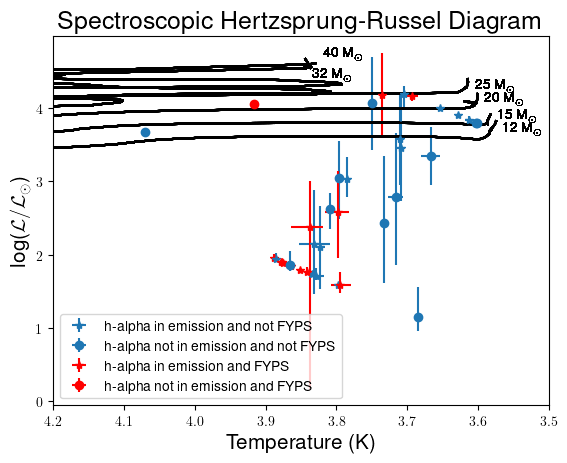

In [28]:
spechr()

In [128]:
def hr():
    """
    generates Hertzsprung Russel diagram
    """
    
    # set labels
    label = 'h-alpha in emission and FYPS'
    label1 = 'h-alpha in emission and not FYPS'
    label2 = 'h-alpha not in emission and FYPS'
    label3 = 'h-alpha not in emission and not FYPS'
    
    
    for i in range(len(mcfiles_sorted)):
        if i == 13:
            samples = loademcee(i,toss=5100)
        else:
            samples = loademcee(i)
        x = samples[:,0] #teff
        y = samples[:,1] #logg
        z = samples[:,4] # radius
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute L with Stefan Boltzmann equation
        L = (((4*np.pi))*(z**2 * u.R_sun**2)*const.sigma_sb*(x**4 * u.K**4)).to(u.L_sun) # Stefan-Boltzmann equation to get L
        sb = np.log10(L.value) # log(L/L_odot)
        
        sbp = np.percentile(sb, [16, 50, 84]) # percentiles of L
        sb_median = sbp[1]
        sb_ul = np.diff(sbp)
        sb_error = [sb_ul[0], sb_ul[1]] # errors
                                         
        # using photometric data
        
        teff_pm = df.teff_pm[i]
        lum = df.lum_pm[i]
        
                            
        
        x_plot = [teff_pm, teff_median] #x vals
        y_plot = [lum, sb_median]#y vals linestyle="--"
        
        genevahr()
        
        # h-alpha in emission - star (circle if not)
        if df.loc[i, 'halpha_emission'] == True:
            # ysg - red (blue if not)
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, sb_median, xerr=1*np.array(teff_error).reshape(-1,1), yerr=1*np.array(sb_error).reshape(-1,1), color='red', fmt='v', label=label)
                plt.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], color='red', fmt='v', mfc='none')
                label = None
            else:
                plt.errorbar(teff_median, sb_median, xerr=1*np.array(teff_error).reshape(-1,1), yerr=1*np.array(sb_error).reshape(-1,1), color='tab:blue', fmt='v', label=label1)
                plt.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], color='tab:blue', fmt='v', mfc='none')
                label1 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, sb_median, xerr=1*np.array(teff_error).reshape(-1,1), yerr=1*np.array(sb_error).reshape(-1,1), color='red', fmt='o', label=label2)
                plt.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], color='red', fmt='o')
                label2 = None
            else:
                plt.errorbar(teff_median, sb_median, xerr=1*np.array(teff_error).reshape(-1,1), yerr=1*np.array(sb_error).reshape(-1,1), color='tab:blue', fmt='o', label=label3)
                plt.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], color='tab:blue', fmt='o', mfc='none')
                label3 = None
        plt.plot(x_plot, y_plot, linestyle='--', color='black')
    plt.xlim(4.2, 3.5)
    plt.ylabel(r'log($L/L_\odot$)', fontsize=15)
    plt.xlabel('Temperature (K)', fontsize=15)
    plt.legend(loc='lower left')
    plt.title('Hertzsprung-Russel Diagram', fontsize=18)

In [126]:
def ll():
    
    label = 'h-alpha in emission and FYPS'
    label1 = 'h-alpha in emission and not FYPS'
    label2 = 'h-alpha not in emission and FYPS'
    label3 = 'h-alpha not in emission and not FYPS'
    
    for i in range(len(mcfiles_sorted)):
        # x-axis
        if i == 13:
            samples = loademcee(i,toss=5100)
        else:
            samples = loademcee(i)
        x = samples[:,0]
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        
        teff_median = df.teff_mc[i]
        
        
        # y-axis, diff between two
        fancyL = df.ifwg_mc[i]
        lum = df.lum_mc[i]
        ll = lum-fancyL
        
        ll_lower = abs((lum-df.lum_lower[i])-(fancyL-df.ifwg_lower[i]))
        ll_upper = abs((df.lum_upper[i]-lum)-(df.ifwg_upper[i]-fancyL))
        
        # errors
        teff_error = [teff_ul[0], teff_ul[1]]
        ll_error = [ll_lower, ll_upper]
        
        #geneva
        genevall()
        
        # plot
        if df.loc[i, 'halpha_emission'] == True:
            # ysg - red (blue if not)
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, ll, xerr=1*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='v', label=label)
                label = None
            else:
                plt.errorbar(teff_median, ll, xerr=1*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='v', label=label1)
                label1 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, ll, xerr=1*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='o', label=label2)
                label2 = None
            else:
                plt.errorbar(teff_median, ll, xerr=1*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='o', label=label3)
                label3 = None
        
        
    plt.xlim(4.2, 3.5)
    plt.ylabel(r'log($L/L_\odot$)-log($\mathcal{L}/\mathcal{L}_\odot$)', fontsize=15)
    plt.xlabel('Temperature (K)', fontsize=15)
    plt.legend(loc='upper left')
    plt.title('Lum-IFWG Diagram', fontsize=18)

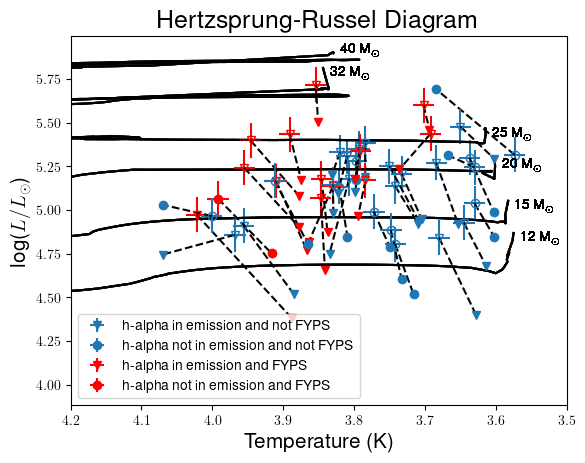

In [129]:
hr()

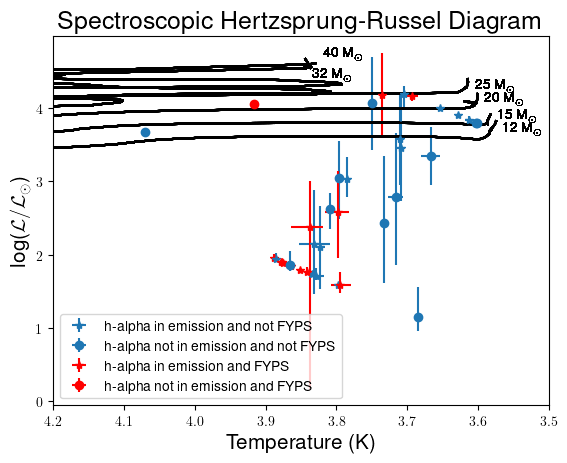

In [23]:
spechr()

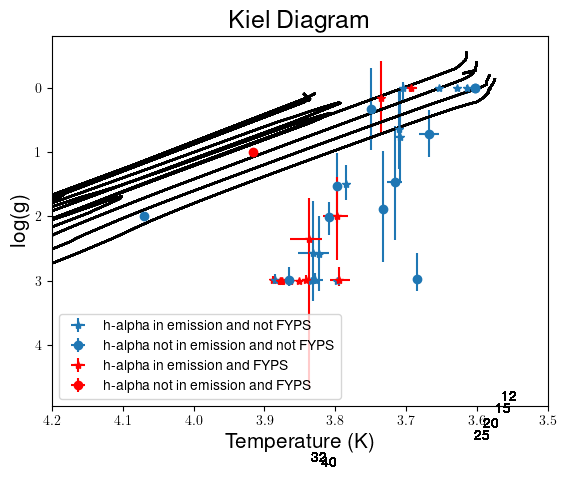

In [24]:
kieldiagram()

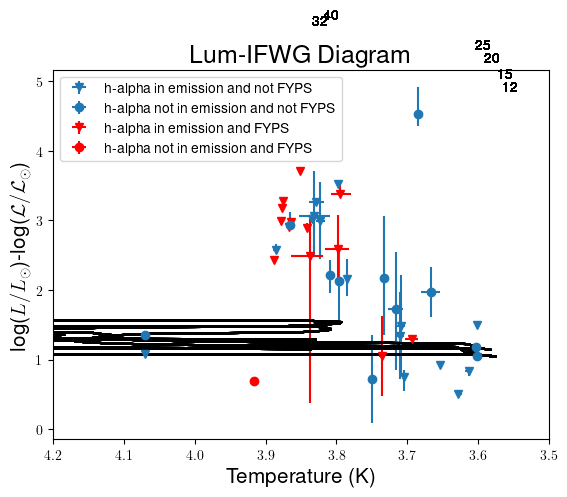

In [25]:
ll()

# Newer plots
These plots are ones I use for presentations and they are more clear and organized than the above ones. 

In [157]:
def spechrbin():
    """
    generates spectroscopic Hertzsprung Russel diagram considering binarity now
    """
    fig, ax = plt.subplots(dpi=300)
    
    # set labels
    red_patch = mpatches.Patch(color='red', label='FYPS')
    blue_patch = mpatches.Patch(color='tab:blue', label='Not FYPS')
    triangle = Line2D([0], [0], label='halpha in emission', marker='v', markeredgewidth=0, markersize=10, markerfacecolor='k', markeredgecolor=None, linestyle='')
    circle = Line2D([0], [0], label='halpha not in emission', marker='o', markeredgewidth=0, markersize=10, markerfacecolor='k', markeredgecolor=None, linestyle='')
    squarebin = Line2D([0], [0], label='binary', marker='s', markersize=10, markerfacecolor='None', markeredgecolor='k', markeredgewidth=2, linestyle='')
    squaremaybe = Line2D([0], [0], label='maybe binary', marker='s', markersize=10, markerfacecolor='None', markeredgecolor='purple', markeredgewidth=2, linestyle='')
    line = Line2D([0], [0], label='Geneva evolutionary track', color='k')
    
    
    
    for i in range(len(mcfiles_sorted)):
        if i == 13:
            samples = loademcee(i,toss=5100)
        else:
            samples = loademcee(i)
        x = samples[:,0]
        y = samples[:,1]
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute fancy L
        fancyL =  4*np.log10(x)-y
        fancyLsun = 4*np.log10(5772)-np.log10(27400)
        
        fancyLp = np.percentile(fancyL, [16, 50, 84]) - fancyLsun # percentiles of fancy L
        l_median = fancyLp[1] # median fancy L
        fancyL_ul = np.diff(fancyLp)

        l_error = [fancyL_ul[0], fancyL_ul[1]] # error bars for L
        genevashr()
        
        if df.loc[i, 'halpha_emission'] == True:
            if df.loc[i, 'FYPS'] == True:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='red', fmt='v', markersize=10, zorder=11)

                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='red', fmt='v', markersize=10, mec='k', markeredgewidth=2, zorder=10)
                    
                else:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='red', fmt='v', markersize=10, mec='rebeccapurple', markeredgewidth=2, zorder=10)
                    
            else:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10)
                    
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, mec='k', markeredgewidth=2)
                    
                else:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, mec='rebeccapurple', markeredgewidth=2)
                    
        else:
            if df.loc[i, 'FYPS'] == True:
                if df.loc[i, 'binary'] == 0:
                    
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='red', fmt='o', markersize=10, zorder=10)
                    
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='red', fmt='o', markersize=10, mec='k', markeredgewidth=2, zorder=10)
                    
                else:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='red', fmt='o', markersize=10, mec='rebeccapurple', markeredgewidth=2, zorder=10)
                    
            else:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10)
                    
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, mec='k', markeredgewidth=2)
                    
                else:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=1*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, mec='rebeccapurple', markeredgewidth=2)
                    
    ax.set_ylabel(r'$\log(\mathcal{L}/\mathcal{L}_\odot)$', fontsize=15)
    ax.set_xlabel(r'$\log(T_{\rm eff})$', fontsize=15)
    ax.legend(loc='lower left', handles=[red_patch, blue_patch, triangle, circle, squarebin, squaremaybe, line])
    ax.set_xlim(4.2, 3.5)
    #ax.set_title('Spectroscopic Hertzsprung-Russel Diagram', fontsize=18)

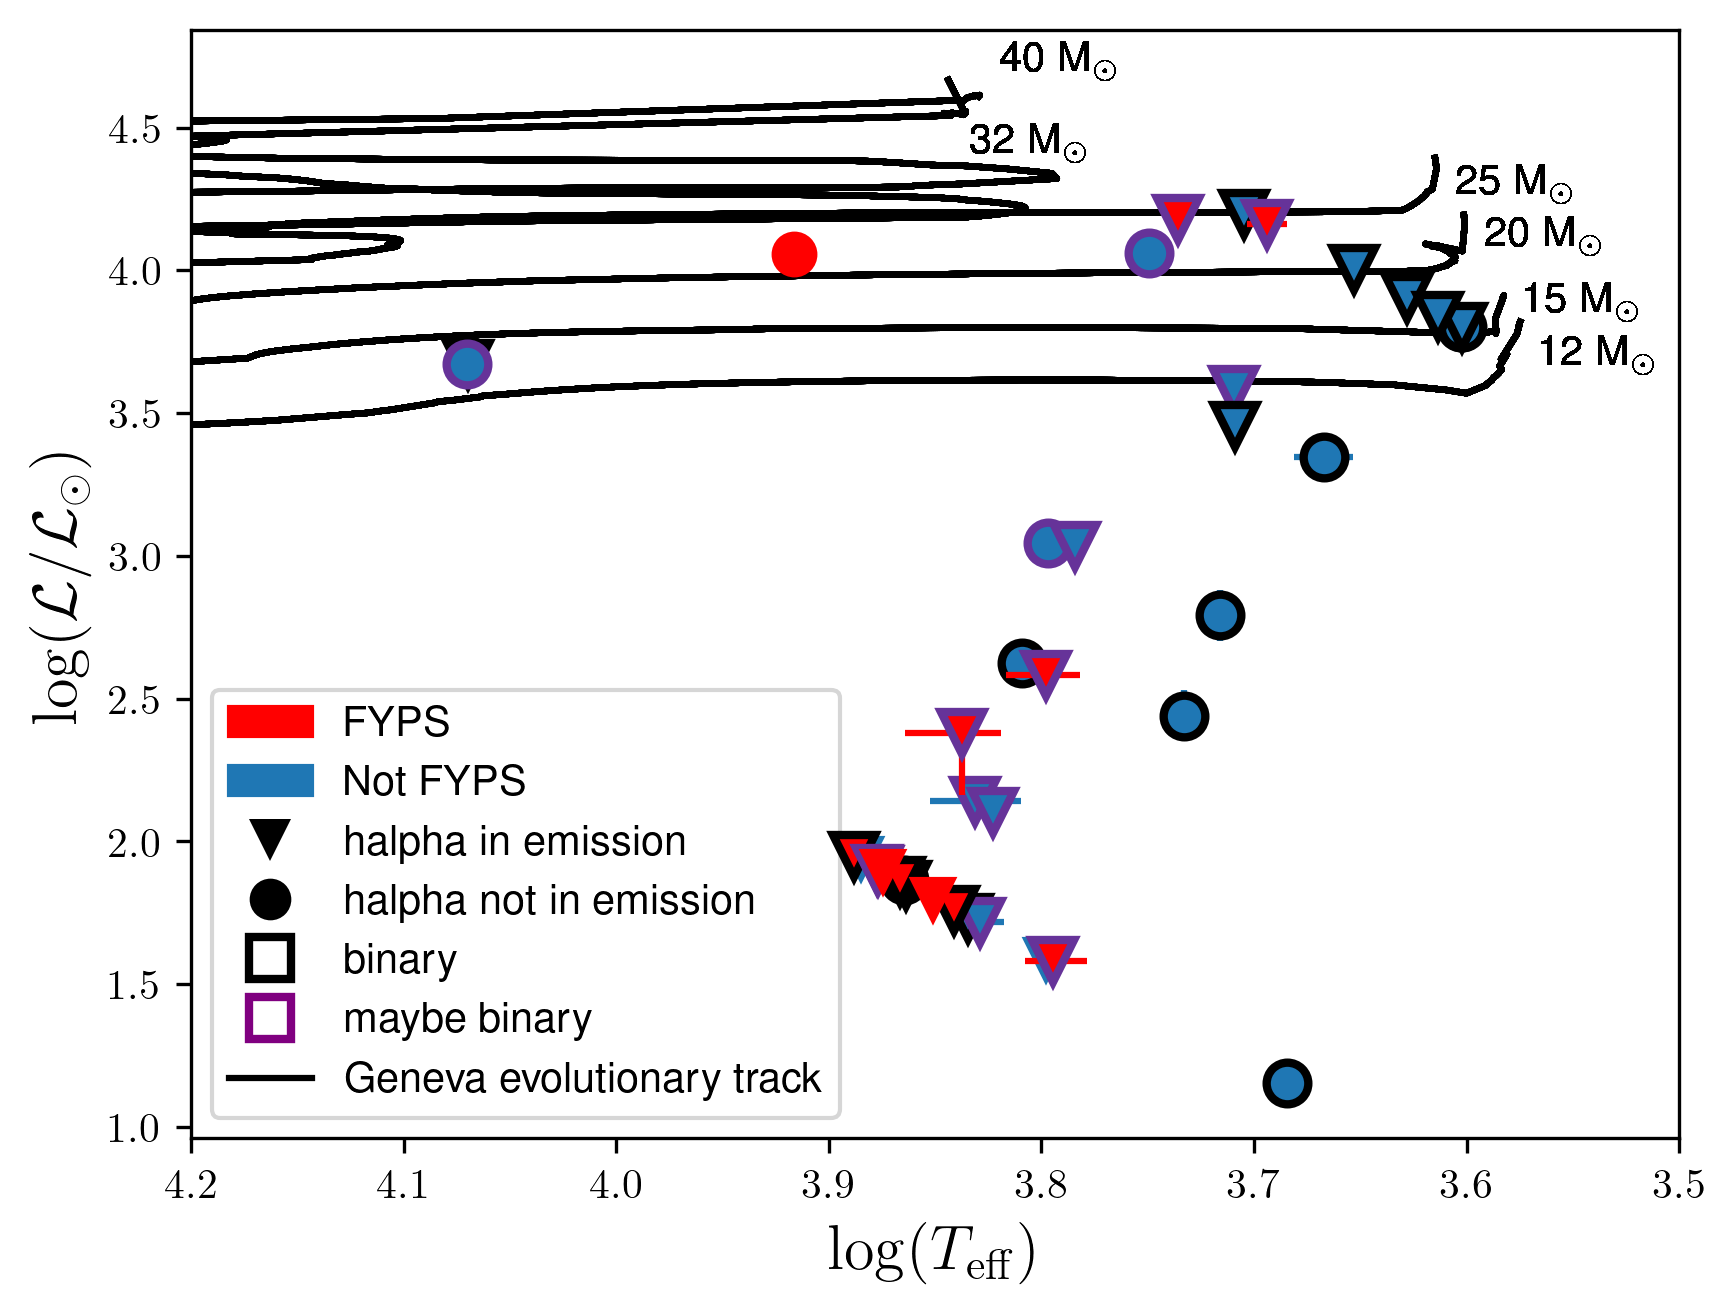

In [158]:
spechrbin()

In [56]:
def llbin():
    """
    creates lum-ifmg diagram and considers if the star is or isn't binary
    """
    
    fig, ax = plt.subplots(dpi=300)
    
    # set labels
    label = 'h-alpha in emission and FYPS not binary'
    label0 = 'h-alpha in emission and FYPS binary'
    label01 = 'h-alpha in emission and FYPS maybe binary'
    label1 = 'h-alpha in emission and not FYPS not binary'
    label10 = 'h-alpha in emission and not FYPS binary'
    label11 = 'h-alpha in emission and not FYPS maybe binary'
    label2 = 'h-alpha not in emission and FYPS not binary'
    label20 = 'h-alpha not in emission and FYPS binary'
    label21 = 'h-alpha not in emission and FYPS maybe binary'
    label3 = 'h-alpha not in emission and not FYPS not binary'
    label30 = 'h-alpha not in emission and not FYPS binary'
    label31 = 'h-alpha not in emission and not FYPS maybe binary'
    
    for i in range(len(mcfiles_sorted)):
        # x-axis
        if i == 13:
            samples = loademcee(i,toss=5100)
        else:
            samples = loademcee(i)
        x = samples[:,0]
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        
        teff_median = df.teff_mc[i]
        
        
        # y-axis, diff between two
        fancyL = df.ifwg_mc[i]
        lum = df.lum_mc[i]
        ll_median = lum-fancyL
        
        ll_lower = abs((lum-df.lum_lower[i])-(fancyL-df.ifwg_lower[i]))
        ll_upper = abs((df.lum_upper[i]-lum)-(df.ifwg_upper[i]-fancyL))
        
        # errors
        teff_error = [teff_ul[0], teff_ul[1]]
        ll_error = [ll_lower, ll_upper]
        
        #geneva
        genevall()
        
        # plot
        
        #halpha emission triangle, circle if not

        if df.loc[i, 'halpha_emission'] == True:
            if df.loc[i, 'FYPS'] == True:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='v', markersize=10, label = label, zorder=11)
                    label = None
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='v', markersize=10, label = label0, mec='k', markeredgewidth=2, zorder=10)
                    label0 = None
                else:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='v', markersize=10, label = label01, mec='rebeccapurple', markeredgewidth=2, zorder=10)
                    label01 = None
            else:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, label = label1)
                    label1 = None
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, label = label10, mec='k', markeredgewidth=2)
                    label10 = None
                else:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, label = label11, mec='rebeccapurple', markeredgewidth=2)
                    label11 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='o', markersize=10, label = label2, zorder=10)
                    label2 = None
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='o', markersize=10, label = label20, mec='k', markeredgewidth=2, zorder=10)
                    label20 = None
                else:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='o', markersize=10, label = label21, mec='rebeccapurple', markeredgewidth=2, zorder=10)
                    label21 = None
            else:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, label = label3)
                    label3 = None
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, label = label30, mec='k', markeredgewidth=2)
                    label30 = None
                else:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, label = label31, mec='rebeccapurple', markeredgewidth=2)
                    label31 = None
        
   # plt.subplots(dpi=300)[1]   
    ax.set_xlim(4.2, 3.5)
    ax.set_ylabel(r'\log($L/L_\odot$)-log($\mathcal{L}/\mathcal{L}_\odot$)', fontsize=15)
    ax.set_xlabel(r'$\log(T_{\rm eff}$)', fontsize=15)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Lum-IFMG Diagram', fontsize=18)

In [57]:
llbin()

Error in callback <function _draw_all_if_interactive at 0x7f8c2a87a7a0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'\\\\log($L/L_{\\\\odot}$)-log($\\\\mathcal{L}/\\\\mathcal{L}_\\\\odot$)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpvejpylx6 e56932243c5178a044ecf3f0ef49e817.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./e56932243c5178a044ecf3f0ef49e817.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file e56932243c5178a044ecf3f0ef49e817.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/local/texlive/2023/texmf-dist/tex/latex/psnfss/ot1phv.fd)
! Missing $ inserted.
<inserted text> 
                $
l.30 {\sffamily \log
                    ($L/L_{\odot}$)-log($\mathcal{L}/\mathcal{L}_\odot$)}%
No pages of output.
Transcript written on tmpvejpylx6/e56932243c5178a044ecf3f0ef49e817.log.




RuntimeError: latex was not able to process the following string:
b'\\\\log($L/L_{\\\\odot}$)-log($\\\\mathcal{L}/\\\\mathcal{L}_\\\\odot$)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmplpzh_333 e56932243c5178a044ecf3f0ef49e817.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./e56932243c5178a044ecf3f0ef49e817.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file e56932243c5178a044ecf3f0ef49e817.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/local/texlive/2023/texmf-dist/tex/latex/psnfss/ot1phv.fd)
! Missing $ inserted.
<inserted text> 
                $
l.30 {\sffamily \log
                    ($L/L_{\odot}$)-log($\mathcal{L}/\mathcal{L}_\odot$)}%
No pages of output.
Transcript written on tmplpzh_333/e56932243c5178a044ecf3f0ef49e817.log.




<Figure size 1920x1440 with 1 Axes>

In [155]:
def hrspec():
    """
    generates Hertzsprung Russel diagram
    """
    fig, ax = plt.subplots(dpi=300)
    
    # set labels
    
    red_patch = mpatches.Patch(color='red', label='FYPS')
    blue_patch = mpatches.Patch(color='tab:blue', label='Not FYPS')
    line = Line2D([0], [0], label='Geneva evolutionary track', color='k')
    
    
    for i in range(len(mcfiles_sorted)):
        if i == 13:
            samples = loademcee(i,toss=5100)
        else:
            samples = loademcee(i)
        x = samples[:,0] #teff
        y = samples[:,1] #logg
        z = samples[:,4] # radius
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute L with Stefan Boltzmann equation
        L = (((4*np.pi))*(z**2 * u.R_sun**2)*const.sigma_sb*(x**4 * u.K**4)).to(u.L_sun) # Stefan-Boltzmann equation to get L
        sb = np.log10(L.value) # log(L/L_odot)
        
        sbp = np.percentile(sb, [16, 50, 84]) # percentiles of L
        sb_median = sbp[1]
        sb_ul = np.diff(sbp)
        sb_error = [sb_ul[0], sb_ul[1]] # errors
                                         
        # using photometric data
        
        teff_pm = df.teff_pm[i]
        lum = df.lum_pm[i]
        
                            
        
        x_plot = [teff_pm, teff_median] #x vals
        y_plot = [lum, sb_median]#y vals linestyle="--"
        
        genevahr()
        

        if df.loc[i, 'FYPS'] == True:
            ax.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1),  markersize=10, color='red', fmt='d')
                
        else:
            ax.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1),  markersize=10, color='tab:blue', fmt='d')
      
    ax.set_xlim(4.2, 3.5)
    ax.set_ylabel(r'$\log(L/L_\odot)$', fontsize=15)
    ax.set_xlabel(r'$\log(T_{\rm eff})$', fontsize=15)
    ax.legend(loc='lower left', handles=[red_patch, blue_patch, line])
#     plt.figure().set_figheight(30)

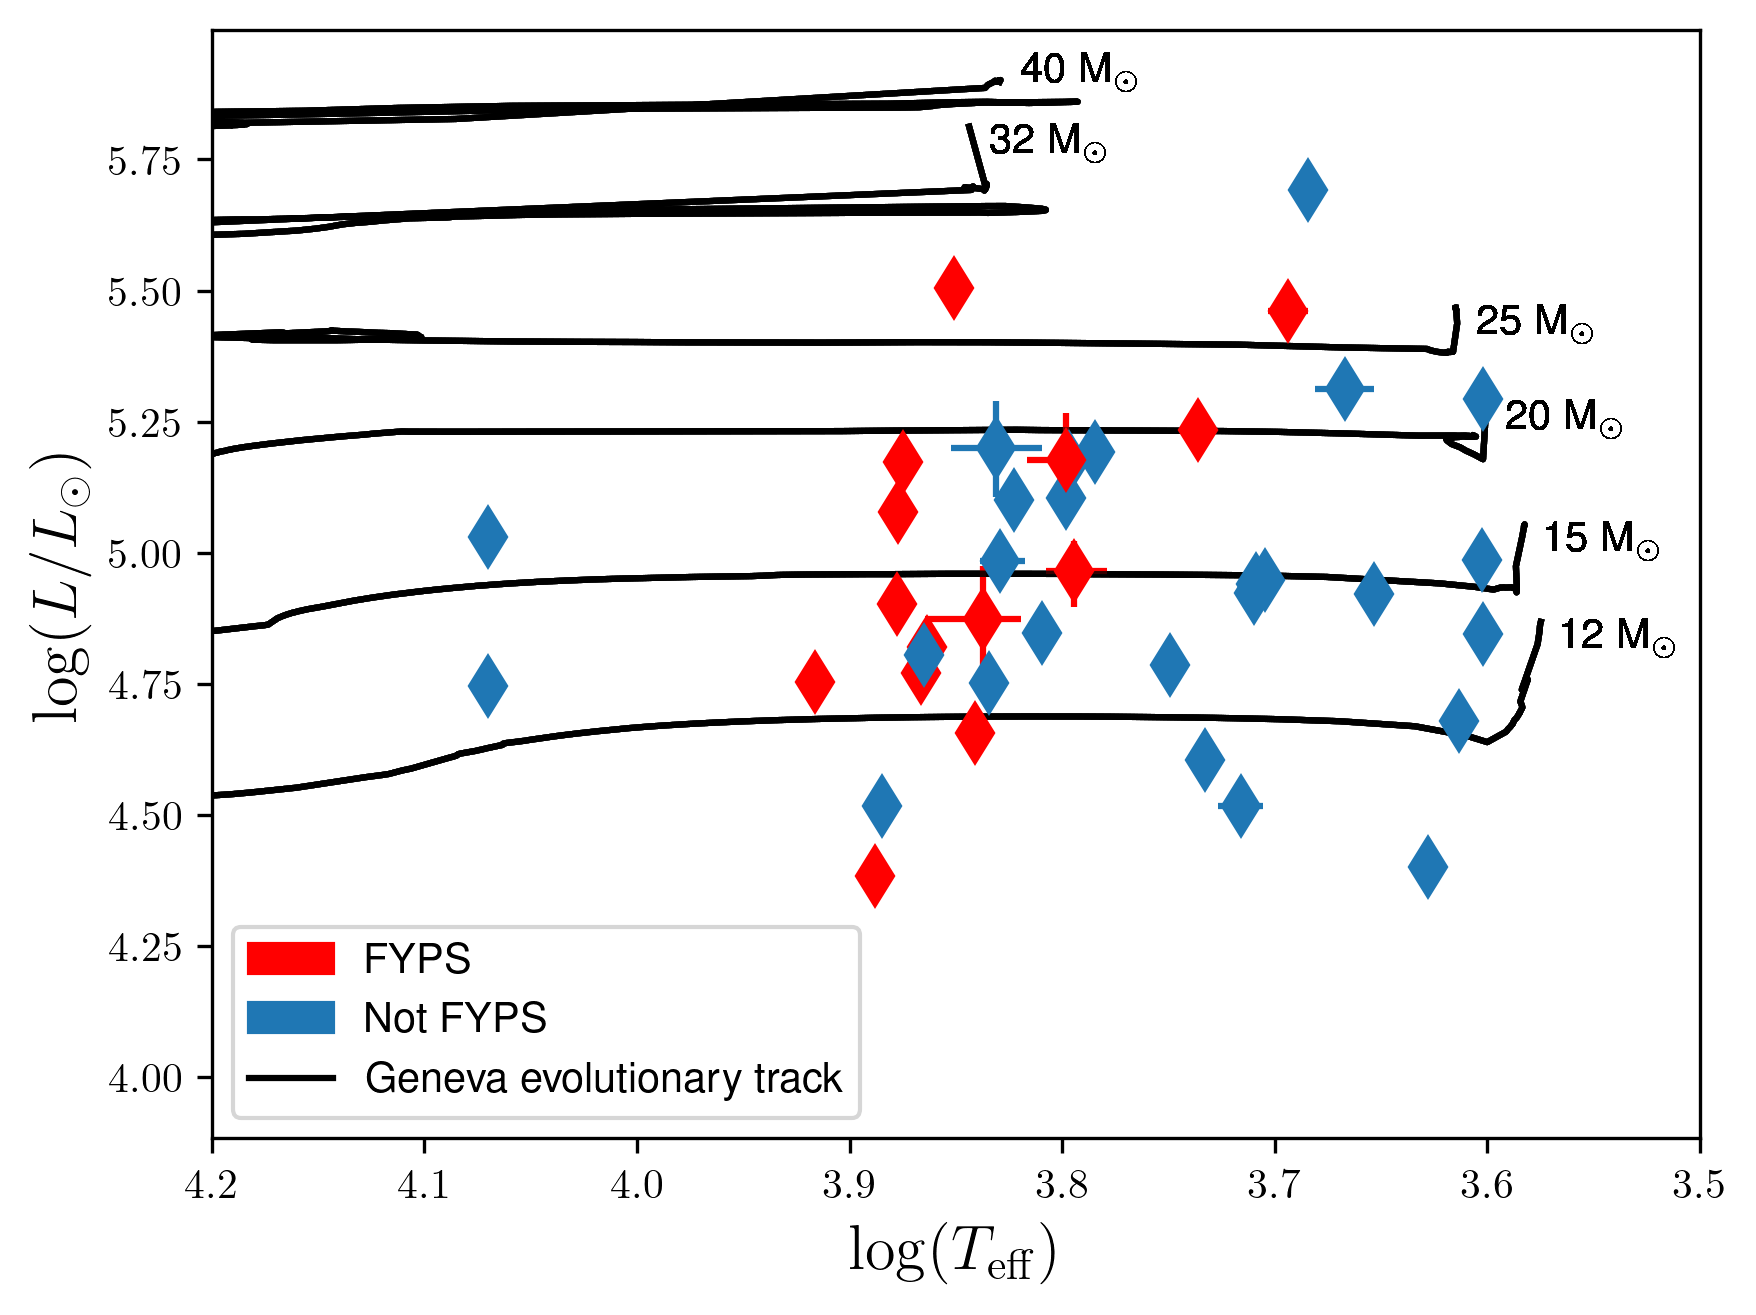

In [156]:
hrspec() # use for poster

In [153]:
def hrpm():
    """
    generates Hertzsprung Russel diagram
    """
    fig, ax = plt.subplots(dpi=300)

    # set labels
    
    red_patch = mpatches.Patch(color='red', label='FYPS')
    blue_patch = mpatches.Patch(color='tab:blue', label='Not FYPS')
    line = Line2D([0], [0], label='Geneva evolutionary track', color='k')
    
    
    for i in range(len(mcfiles_sorted)):
        if i == 13:
            samples = loademcee(i,toss=5100)
        else:
            samples = loademcee(i)
        x = samples[:,0] #teff
        y = samples[:,1] #logg
        z = samples[:,4] # radius
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute L with Stefan Boltzmann equation
        L = (((4*np.pi))*(z**2 * u.R_sun**2)*const.sigma_sb*(x**4 * u.K**4)).to(u.L_sun) # Stefan-Boltzmann equation to get L
        sb = np.log10(L.value) # log(L/L_odot)
        
        sbp = np.percentile(sb, [16, 50, 84]) # percentiles of L
        sb_median = sbp[1]
        sb_ul = np.diff(sbp)
        sb_error = [sb_ul[0], sb_ul[1]] # errors
                                         
        # using photometric data
        
        teff_pm = df.teff_pm[i]
        lum = df.lum_pm[i]
        
                            
        
        x_plot = [teff_pm, teff_median] #x vals
        y_plot = [lum, sb_median]#y vals linestyle="--"
        
        genevahr()
        
        if df.loc[i, 'FYPS'] == True:
            ax.errorbar(teff_pm, lum, xerr=[.015], yerr=[.1],  markersize=10, color='red', fmt='d', markerfacecolor='none')
                
        else:
            ax.errorbar(teff_pm, lum, xerr=[.015], yerr=[.1],  markersize=10, color='tab:blue', fmt='d', markerfacecolor='none')
      
    ax.set_xlim(4.2, 3.5)
    ax.set_ylabel(r'$\log(L/L_\odot)$', fontsize=15)
    ax.set_xlabel(r'$\log(T_{\rm eff})$', fontsize=15)
    plt.legend(loc='lower left', handles=[red_patch, blue_patch, line])

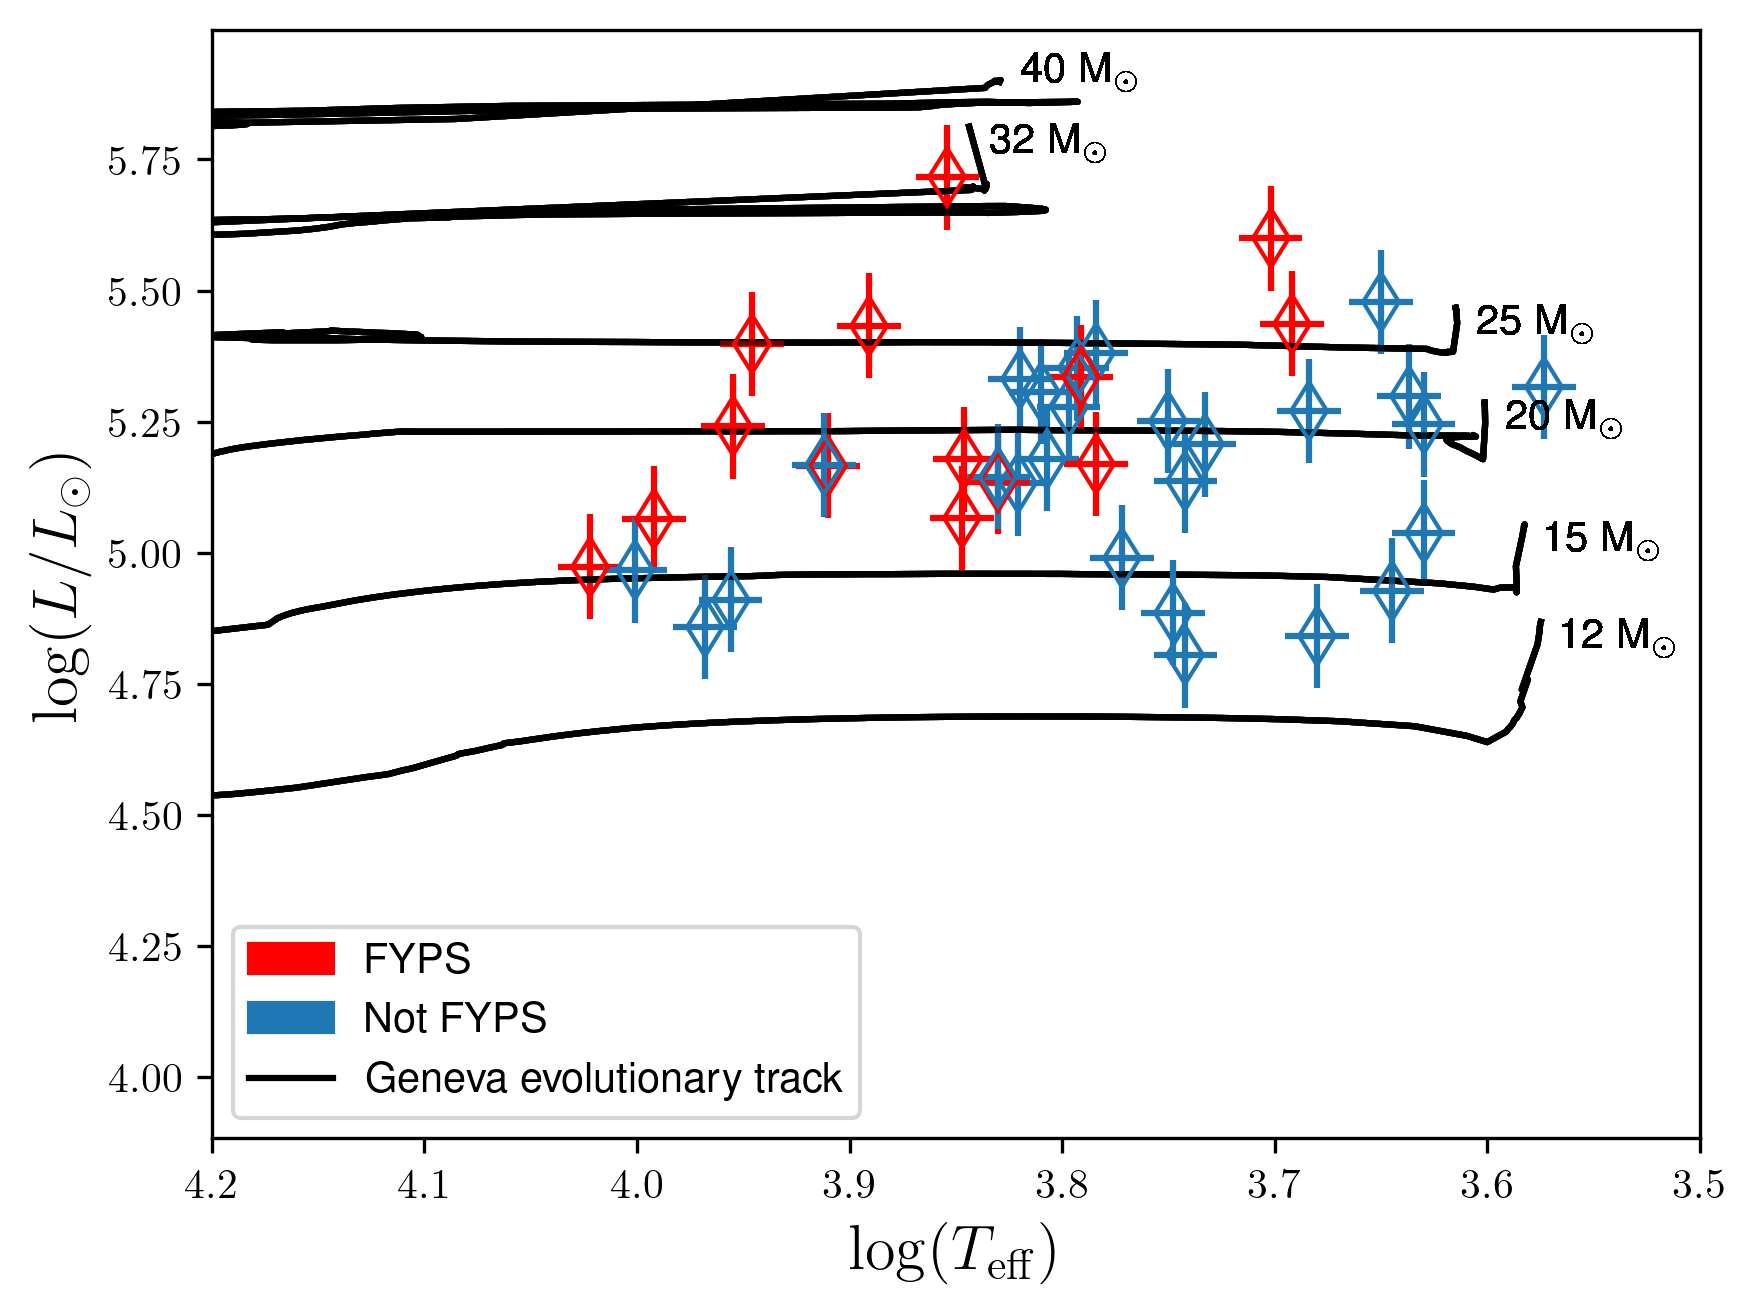

In [154]:
hrpm()

In [28]:
def histteff():
    """
    differences in teff from mc values vs photometric
    """
    fig, ax = plt.subplots(dpi=300)
    x = []
    for i in range(len(mcfiles_sorted)):
        diff = df.loc[i, 'teff_mc']-df.loc[i, 'teff_pm']
        x.append(diff)
    ax.hist(x, bins='auto')
    ax.set_xlabel(r'$\Delta\log{T_{\rm eff}}$', fontsize=15)
    ax.set_ylabel('Number of Stars', fontsize=15)

## Quantifying differences: spec vs. pm
Photometric data is generally more clustered and inaccurate. We quantify the differences from my data and the photometric data, finding that the values are relatively similar. But, the luminosities for spectroscopic data were found to be ~20% lower than the photometric. The temperatures detected were also higher.

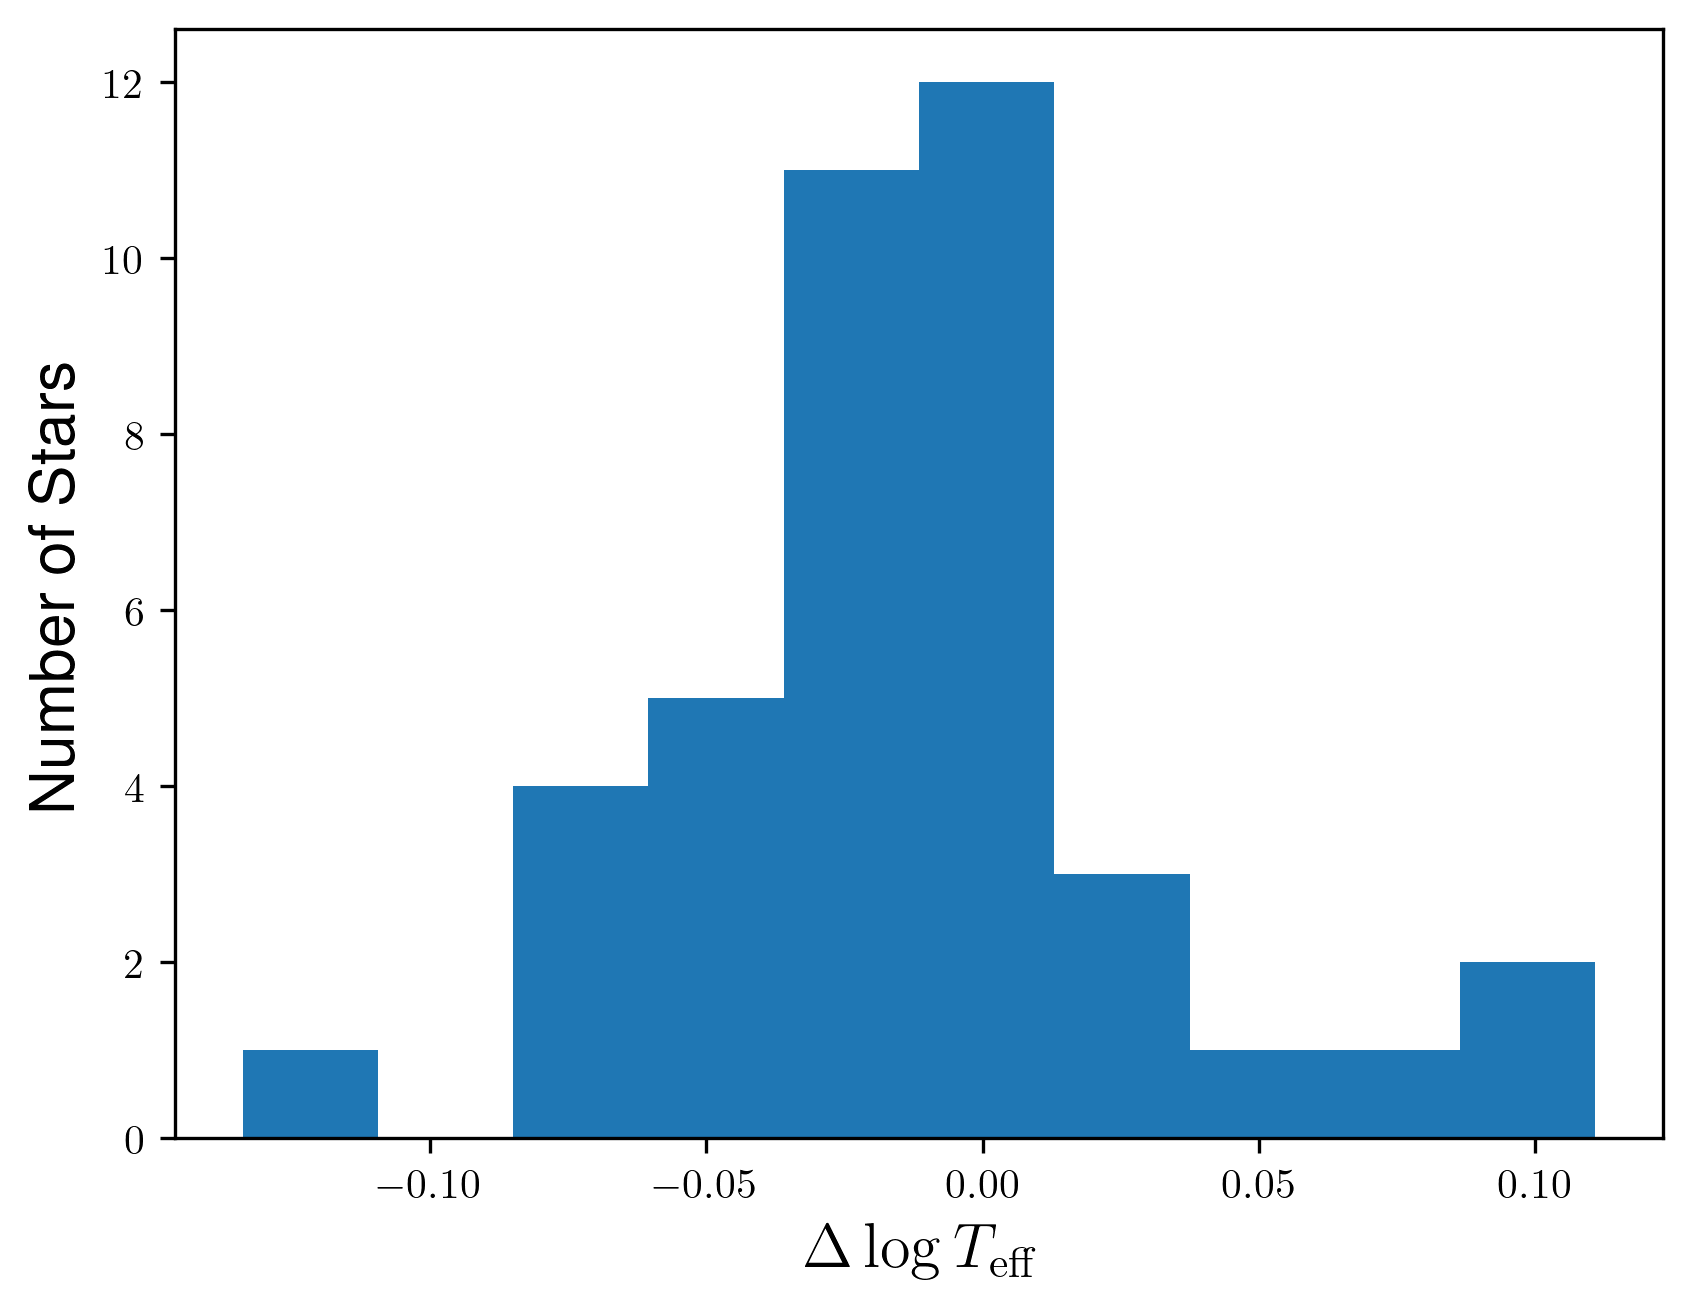

In [29]:
histteff()

In [30]:
def histlum():
    """
    differences in log(L) from mc values vs photometric
    """
    fig, ax = plt.subplots(dpi=300)
    x = []
    for i in range(len(mcfiles_sorted)):
        diff = df.loc[i, 'lum_mc']-df.loc[i, 'lum_pm']
        x.append(diff)
    ax.hist(x, bins='auto')
    ax.set_xlabel(r'$\Delta\log{L/L_\odot}$', fontsize=15)
    ax.set_ylabel('Number of Stars', fontsize=15)

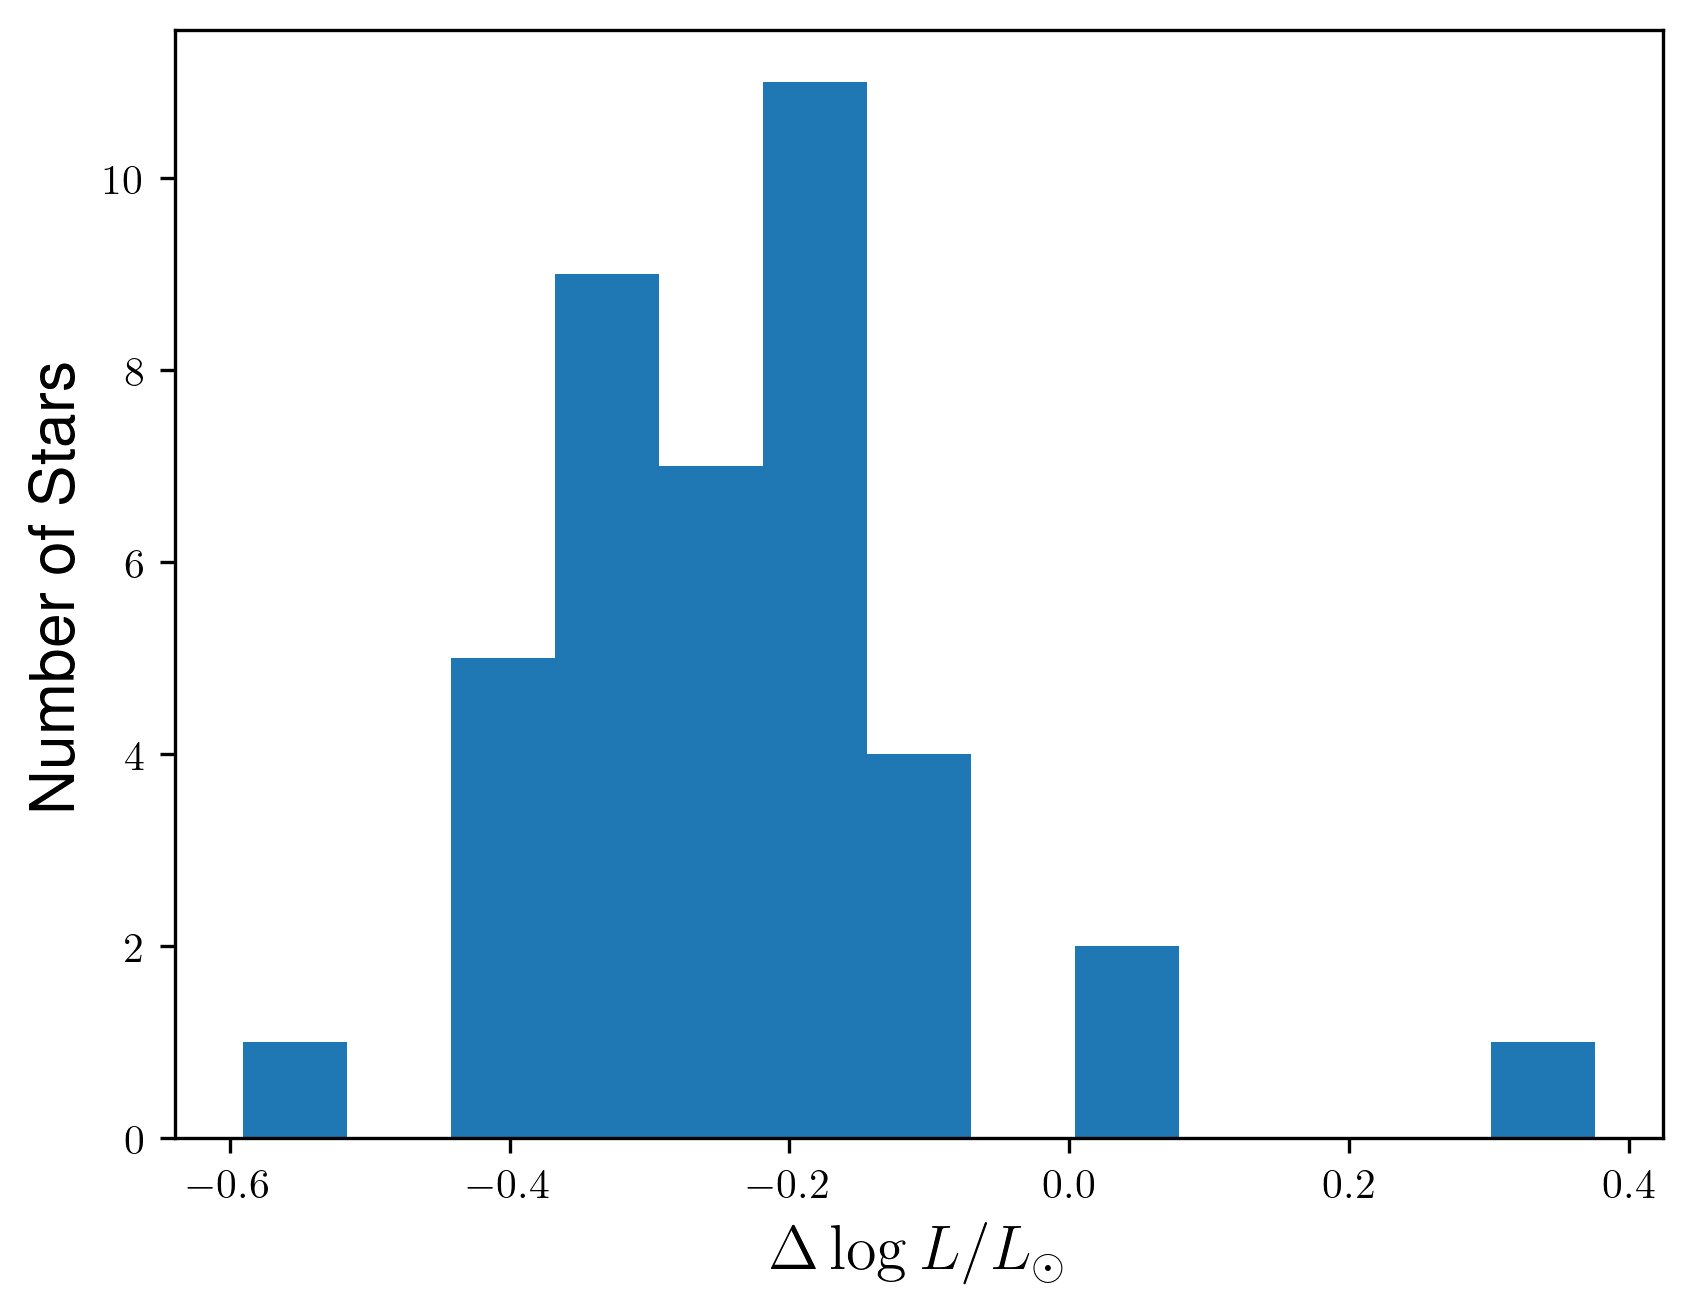

In [31]:
histlum()